In [2]:
!pip install -r requirements.txt

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
import os
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture

# --- Environment Setup ---
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['JOBLIB_LOKY_BACKEND'] = 'threading'
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

# Load and prep data
file_path = 'Mall_Customers.csv'
df = pd.read_csv(file_path)
X = df[['Annual Income (k$)', 'Spending Score (1-100)']] 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Data loaded and scaled.")

Data loaded and scaled.


In [10]:
# 1. Get labels for all final models
k_optimal = 5
# K-Means (K=5)
labels_km = KMeans(n_clusters=k_optimal, random_state=42, n_init=10).fit_predict(X_scaled)
# Hierarchical (K=5)
labels_hc = AgglomerativeClustering(n_clusters=k_optimal).fit_predict(X_scaled)
eps_opt = 0.36
min_s_opt = 5
labels_db = DBSCAN(eps=eps_opt, min_samples=min_s_opt).fit_predict(X_scaled)
# GMM (K=5)
labels_gmm = GaussianMixture(n_components=k_optimal, random_state=42).fit_predict(X_scaled)

models = {
    'K-Means (K=5)': labels_km,
    'Hierarchical (K=5)': labels_hc,
    'DBSCAN (eps=0.35)': labels_db,
    'GMM (K=5)': labels_gmm
}

metrics_data = {}

# 2. Calculate metrics for each model
for model_name, labels in models.items():
    # Filter out noise (-1) for DBSCAN when calculating metrics
    mask = labels != -1
    if not np.any(mask): 
        print(f"Skipping {model_name}: All points are noise.")
        continue
    
    X_filtered = X_scaled[mask]
    labels_filtered = labels[mask]
    
    # Check if more than 1 cluster exists (required for metrics)
    if len(np.unique(labels_filtered)) < 2:
        print(f"Skipping {model_name}: Only one cluster found.")
        s_score, c_score, d_score = np.nan, np.nan, np.nan
    else:
        s_score = silhouette_score(X_filtered, labels_filtered)
        c_score = calinski_harabasz_score(X_filtered, labels_filtered)
        d_score = davies_bouldin_score(X_filtered, labels_filtered)
    
    metrics_data[model_name] = [s_score, c_score, d_score]

# 3. Display as a DataFrame
metrics_df = pd.DataFrame.from_dict(
    metrics_data, 
    orient='index', 
    columns=['Silhouette (Higher)', 'Calinski-Harabasz (Higher)', 'Davies-Bouldin (Lower)']
)
print("\n--- Internal Evaluation Metrics Comparison ---")
print(metrics_df)


--- Internal Evaluation Metrics Comparison ---
                    Silhouette (Higher)  Calinski-Harabasz (Higher)  \
K-Means (K=5)                  0.554657                  248.649320   
Hierarchical (K=5)             0.553809                  244.410326   
DBSCAN (eps=0.35)              0.549944                  239.625956   
GMM (K=5)                      0.553689                  244.940197   

                    Davies-Bouldin (Lower)  
K-Means (K=5)                     0.572236  
Hierarchical (K=5)                0.577862  
DBSCAN (eps=0.35)                 0.513190  
GMM (K=5)                         0.576010  


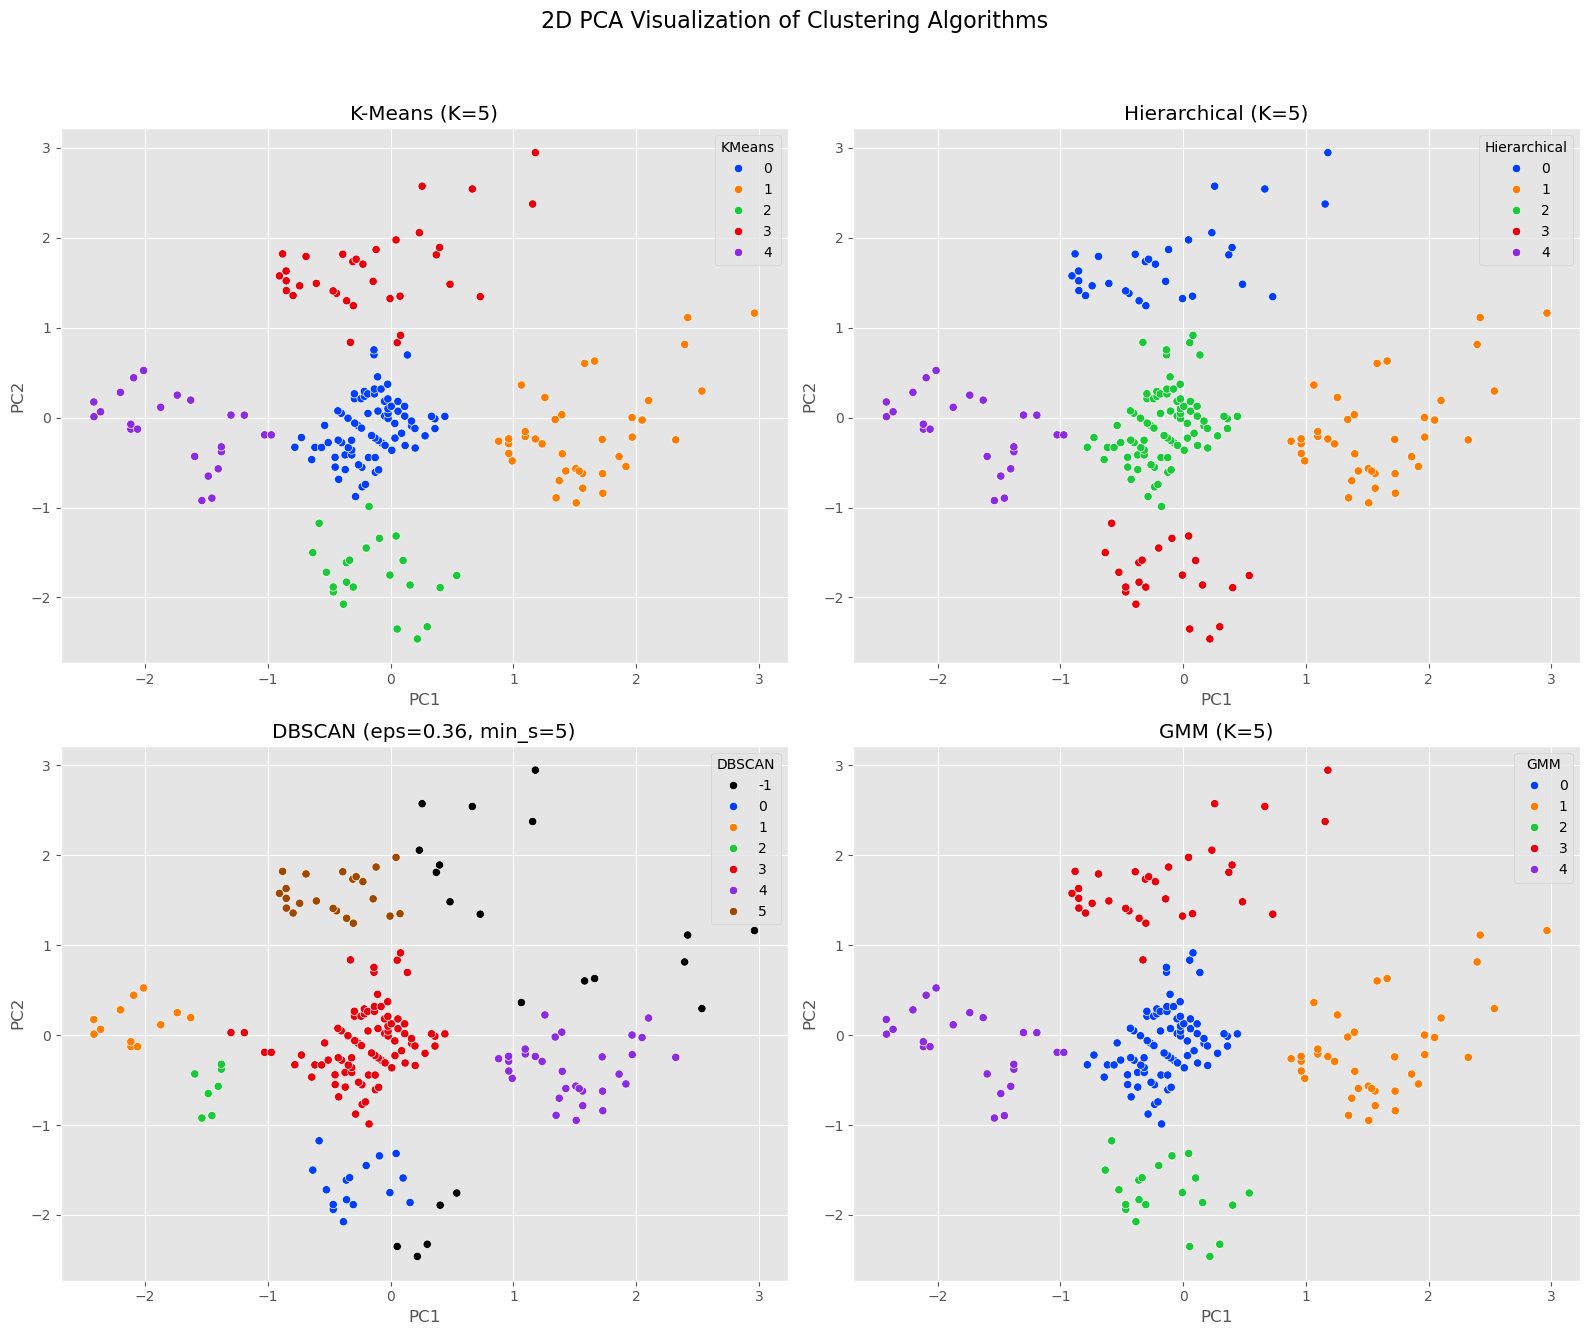

In [18]:
from sklearn.decomposition import PCA

# 1. Apply PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# 2. Create DataFrame for plotting
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['KMeans'] = pd.Categorical(labels_km)
df_pca['Hierarchical'] = pd.Categorical(labels_hc)
df_pca['DBSCAN'] = pd.Categorical(labels_db)
df_pca['GMM'] = pd.Categorical(labels_gmm)

# 3. Create 2x2 Subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
fig.suptitle('2D PCA Visualization of Clustering Algorithms', fontsize=16)

# Plot K-Means
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='KMeans', palette='bright', ax=axes[0, 0], legend='full')
axes[0, 0].set_title('K-Means (K=5)')

# Plot Hierarchical
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Hierarchical', palette='bright', ax=axes[0, 1], legend='full')
axes[0, 1].set_title('Hierarchical (K=5)')

# Plot DBSCAN
n_clusters_db = len(np.unique(labels_db)) - (1 if -1 in labels_db else 0)
db_colors = sns.color_palette('bright', n_colors=n_clusters_db)
db_palette = {label: color for label, color in zip(range(n_clusters_db), db_colors)}
db_palette[-1] = (0, 0, 0, 1) # Black for noise
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='DBSCAN', palette=db_palette, ax=axes[1, 0], legend='full')
axes[1, 0].set_title(f'DBSCAN (eps={eps_opt}, min_s={min_s_opt})')

# Plot GMM
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='GMM', palette='bright', ax=axes[1, 1], legend='full')
axes[1, 1].set_title('GMM (K=5)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

Running Hierarchical Clustering (K=5) to get labels for sorting...
Matrix sorted by cluster label.


Text(119.44444444444444, 0.5, 'Data Points (Sorted by Cluster)')

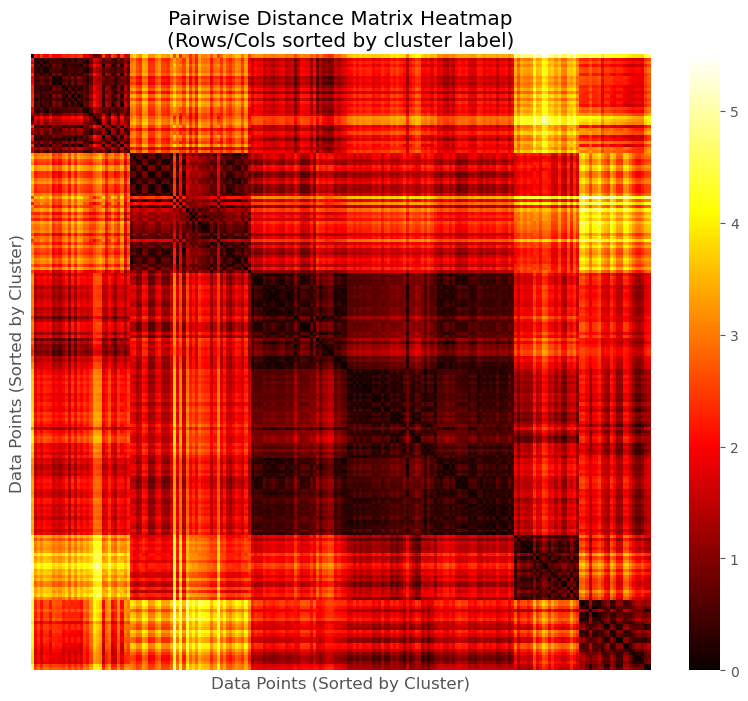

In [28]:
from sklearn.metrics import pairwise_distances # To create the matrix
from sklearn.cluster import AgglomerativeClustering # To get labels for sorting

# --- 1. Get Cluster Labels for Sorting ---
print("Running Hierarchical Clustering (K=5) to get labels for sorting...")
k = 5
hc = AgglomerativeClustering(n_clusters=k, linkage='ward')
labels = hc.fit_predict(X_scaled)
df['HC_Cluster'] = labels

# --- 2. Compute Pairwise Distance Matrix ---
dist_matrix = pairwise_distances(X_scaled, metric='euclidean')

# --- 3. Sort the Matrix by Cluster Label ---
sorted_indices = df.sort_values(by='HC_Cluster').index

# Re-order the rows and columns of the distance matrix
sorted_dist_matrix = dist_matrix[sorted_indices, :][:, sorted_indices]
print("Matrix sorted by cluster label.")

# --- 4. Visualize the Sorted Matrix ---
plt.figure(figsize=(10, 8))

sns.heatmap(
    sorted_dist_matrix,
    cmap='hot',
    xticklabels=False, # Hide 200 labels
    yticklabels=False  # Hide 200 labels
)

plt.title("Pairwise Distance Matrix Heatmap\n(Rows/Cols sorted by cluster label)")
plt.xlabel("Data Points (Sorted by Cluster)")
plt.ylabel("Data Points (Sorted by Cluster)")